<a href="https://colab.research.google.com/github/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install tabulate

In [43]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import scipy

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import * 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

import torch
import torch.nn as nn 


# import warnings
# warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

DLed = False

In [44]:
if not DLed:
    train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
    test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
    DLed = True
    
combined_data = pd.concat([train, test]).drop(columns=['id', 'label'])
combined_data.shape
combined_data.head(5)

(257673, 43)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal


In [45]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
print('Train ', round(len(tmp['attack_cat'])/len(train['attack_cat']),5))

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print('Test ', round(len(tmp['attack_cat'])/len(test['attack_cat']),5))

# del train, test

Train  0.31938
Test  0.4494


In [46]:
le = LabelEncoder()

vector = combined_data['attack_cat']
print("attack cats:", list(set(list(vector)))) # use print to make it print on single line 

combined_data['attack_cat'] = le.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

print('\nDescribing attack types: ')

print("mode", vector.mode())
print(f"mode {np.sum(combined_data['attack_cat'].values==6)/vector.shape[0]:.2f}%") # alt numerator:  len(np.where(combined_data['attack_cat'].values==6)[0])

print("looks like 6 is 'normal', but its not that common")

attack cats: ['Exploits', 'Generic', 'Reconnaissance', 'DoS', 'Fuzzers', 'Analysis', 'Shellcode', 'Backdoor', 'Worms', 'Normal']

Describing attack types: 
mode 0    Normal
Name: attack_cat, dtype: object
mode 0.36%
looks like 6 is 'normal', but its not that common


In [47]:
import collections
from tabulate import tabulate

counter = collections.Counter(vector)  
print(tabulate(counter.most_common(),headers = ['Type','Occurences']))

Type              Occurences
--------------  ------------
Normal                 93000
Generic                58871
Exploits               44525
Fuzzers                24246
DoS                    16353
Reconnaissance         13987
Analysis                2677
Backdoor                2329
Shellcode               1511
Worms                    174


In [48]:
COPY = combined_data.copy(deep=True)

In [49]:
combined_data = COPY
assert COPY.shape == combined_data.shape

lowSTD = list(combined_data.std().to_frame().nsmallest(7, columns=0).index)
lowCORR = list(combined_data.corr().abs().sort_values('attack_cat')['attack_cat'].nsmallest(7).index) # .where(lambda x: x < 0.005).dropna()

In [50]:
exclude = list(lowCORR + lowSTD)
if 'attack_cat' in exclude:
  exclude.remove('attack_cat')

print('shape before:', combined_data.shape)
print('replace the following with their PCA(3) -', exclude)

# dim_reduct = SparsePCA(10, n_jobs = -1).fit_transform(combined_data)
# dim_reduct = TruncatedSVD(4).fit_transform(combined_data[exclude])
pca = PCA(3)
dim_reduct = pca.fit_transform(combined_data[exclude])

print("explained_variance_ratio_ is", sum(pca.explained_variance_ratio_))

combined_data.drop(exclude,axis=1,inplace=True)

dim_reduction = pd.DataFrame(dim_reduct)
combined_data = combined_data.join(dim_reduction)

print('shape after:', combined_data.shape)


shape before: (257673, 43)
replace the following with their PCA(3) - ['sjit', 'response_body_len', 'djit', 'dinpkt', 'dbytes', 'spkts', 'dloss', 'ackdat', 'synack', 'tcprtt', 'is_ftp_login', 'ct_ftp_cmd', 'is_sm_ips_ports', 'ct_flw_http_mthd']
explained_variance_ratio_ is 0.9995382828842387
shape after: (257673, 32)


In [51]:
print('combined_data.dur is scaled up by 10,000')
combined_data['dur'] = 10000*combined_data['dur']
combined_data.head()

combined_data.dur is scaled up by 10,000


,dur,proto,service,state,dpkts,sbytes,rate,sttl,dttl,sload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,attack_cat,0,1,2
0,1214.78,113,0,4,4,258,74.087490,252,254,14158.942380,...,1,1,1,1,1,1,6,-14339.811230,-5427.117131,363.455824
1,6499.02,113,0,4,38,734,78.473372,62,252,8395.112305,...,1,1,1,2,1,6,6,26947.677836,-5283.049895,-6435.428556
2,16231.29,113,0,4,16,364,14.170161,62,252,1572.271851,...,2,1,1,3,2,6,6,-1508.847447,12187.598091,-1747.491867
3,16816.42,113,3,4,12,628,13.677108,62,252,2740.178955,...,2,1,1,3,2,1,6,-13744.620251,-4994.575427,262.769642
4,4494.54,113,0,4,6,534,33.373826,254,252,8561.499023,...,2,2,1,40,2,39,6,-14248.116190,-3038.320683,349.430503


In [52]:
print('before:', combined_data.shape)
data_x = combined_data.drop(['attack_cat'], axis=1) # droped label
data_y = combined_data['attack_cat']
data_x.shape
data_y.shape

data_x = data_x.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# data_x = MinMaxScaler().fit_transform(data_x) # better for VotingClassifier
# data_x = StandardScaler().fit_transform(data_x)


before: (257673, 32)


(257673, 31)

(257673,)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.50, random_state=42) # TODO test_size depends on how much you are willing to wait... :)

In [57]:
DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier(n_estimators=50, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=75, criterion='gini', max_features='sqrt', bootstrap=False)

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC), ('et', ETC)], voting='hard')
for clf, label in zip([DTC, RFC, ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']):
    _ = clf.fit(X_train, y_train)
    pred = clf.score(X_test, y_test)
    print("Acc: %0.7f [%s]" % (pred, label))


Acc: 0.8086264 [DecisionTreeClassifier]
Acc: 0.8344109 [RandomForestClassifier]
Acc: 0.8291097 [ExtraTreesClassifier]
Acc: 0.8339452 [Ensemble]


In [59]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# Crearea și antrenarea RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe.fit(X_train, y_train)

# Obținerea index-urilor caracteristicilor selectate
desiredIndices = np.where(rfe.support_ == True)[0]

# Convertirea datelor în DataFrame pentru manipulare mai ușoară
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

# Extracția caracteristicilor selectate
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE, X_test_RFE = X_train[whitelist], X_test[whitelist]

# Clasificatori pentru VotingClassifier
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=50, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=75, criterion='gini', max_features='sqrt', bootstrap=False)  # corectat max_features

# Antrenarea clasificatorilor
eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC), ('et', ETC)], voting='hard') 
for clf, label in zip([DTC, RFC, ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
    _ = clf.fit(X_train_RFE, y_train)  # Utilizare X_train_RFE cu caracteristicile selectate
    pred = clf.score(X_test_RFE, y_test)  # Evaluare pe X_test_RFE
    print("Acc: %0.7f [%s]" % (pred, label))


RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)

Acc: 0.8027430 [DecisionTreeClassifier]
Acc: 0.8254616 [RandomForestClassifier]
Acc: 0.8248174 [ExtraTreesClassifier]
Acc: 0.8249261 [Ensemble]


In [60]:
X_train_RFE.shape
set(y_train)

# X_train_RFE.dtype = np.int


# torch.as_tensor(X_train_RFE_vals[i].astype('double'),dtype=torch.double)

(128836, 10)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Neural network

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

input_size = 10
hidden_size = 64 
hidden_size_2 = 64
num_classes = 10

num_epochs = 40
batch_size = 32
learning_rate = 0.001

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size # ?? 
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size_2)  
        self.l3 = nn.Linear(hidden_size_2, num_classes)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        # no activation and no softmax at the end
        return out

In [62]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(X_train)

X_train_RFE_vals= X_train_RFE.values
y_train_vals = y_train.values

for epoch in range(num_epochs):
    # for i in range(len(X_train_RFE_vals)//100 + 1): #, batch_size
    for i in range(0, X_train_RFE_vals.shape[0], batch_size):


        x = torch.as_tensor(X_train_RFE_vals[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_train_vals[i:i+batch_size], dtype=torch.long).to(device)

        # x.type()
        # y.type()
        
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [10/40], Step [128833/128836], Loss: 0.0096
Epoch [20/40], Step [128833/128836], Loss: 0.0035
Epoch [30/40], Step [128833/128836], Loss: 0.0028
Epoch [40/40], Step [128833/128836], Loss: 0.0029


In [63]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
X_test_RFE_vals= X_test_RFE.values
y_test_vals = y_test.values
with torch.no_grad():
    n_correct = 0
    n_samples = 0 
    # for i in range(len(X_train_RFE_vals)//100 + 1):   
    for i in range(0, X_test_RFE_vals.shape[0], batch_size):
        x = torch.as_tensor(X_test_RFE_vals[i:i+batch_size], dtype=torch.float).to(device)
        y = torch.as_tensor(y_test_vals[i:i+batch_size], dtype=torch.long).to(device)
        
        outputs = model(x)
        if len(outputs.data) > 0:
          # max returns (value ,index)
          _, predicted = torch.max(outputs.data, dim=1)
          n_samples += y.size(0)
          n_correct += (predicted == y).sum().item()
        else:
          print("what???")
          print(x, outputs.data)
    acc = 100.0 * n_correct / (n_samples+1)
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 78.95807137645726 %


## autoEncoder

In [64]:
import copy

device = 'cpu' # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, center_size):
    super(Encoder, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size) 
    self.l2 = nn.Linear(hidden_size, center_size)  
    self.acti = nn.ELU()
    
  def forward(self, x):
    out = self.l1(x)
    out = self.acti(out)
    out = self.l2(out)
    return out

class Decoder(nn.Module):   
  def __init__(self, output_size, hidden_size, center_size):
    super(Decoder, self).__init__()
    self.l1 = nn.Linear(center_size, hidden_size) 
    self.l2 = nn.Linear(hidden_size, output_size)  
    self.acti = nn.ELU()
    
  def forward(self, x):
    out = self.l1(x)
    out = self.acti(out)
    out = self.l2(out)
    return out

In [66]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, center_size):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(input_size, hidden_size, center_size).to(device)
    self.decoder = Decoder(output_size, hidden_size, center_size).to(device)
    print(self.encoder)
    print(self.decoder)

  def forward(self, x):
    encoded = self.encoder(x)
    dencoded = self.decoder(encoded)
    return dencoded

In [67]:
def train_model(model, train_dataset, val_dataset, n_epochs, batch_size, lr):

  optimizer = torch.optim.Adam(model.parameters(), lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
  criterion = nn.MSELoss(reduction='sum').to(device) #L1Loss(reduction='sum').to(device) # nn.SmoothL1Loss
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    
    train_losses = []
    model = model.train()
    for i in range(0, train_dataset.shape[0], batch_size):
      seq_true = train_dataset[i:i+batch_size]
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())


    val_losses = []
    model = model.eval()
    with torch.no_grad():
      # for seq_true in val_dataset:
      for i in range(0, val_dataset.shape[0], batch_size):
        seq_true = val_dataset[i:i+batch_size]
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    scheduler.step(val_loss) # ReduceLROnPlateau
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train_loss: {train_loss:.8f}\t val_loss: {val_loss:.8f}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

### Experiment for autoencoder
> keep only the features that have a "huge" difference between normal and attack  

VotingClassifier 83% -> 76% acc

AutoEncoder 88.3%-> 82.1%

In [68]:
EXPERIMENT = False 

if EXPERIMENT:
  tmp_1 = combined_data[combined_data['attack_cat'] == 6].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
  tmp_2 = combined_data[combined_data['attack_cat'] != 6].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

  # tmp = tmp.apply(lambda x: round(x,8)) #  0.66666667
  tmp_3 = np.abs(tmp_1.describe()[1:3] - tmp_2.describe()[1:3])
  # tmp_3

  tmp_4 = tmp_3.T[tmp_3.T['mean'] > 0.1]
  tmp_4.T

  test_keep = tmp_4.index

  normal = combined_data[combined_data['attack_cat']==6].drop(['attack_cat'], axis=1)[test_keep]
  attack = combined_data[combined_data['attack_cat']!=6].drop(['attack_cat'], axis=1)[test_keep]

else:
  normal = combined_data[combined_data['attack_cat']==6].drop(['attack_cat'], axis=1).apply(lambda x: (x - x.min()) / (x.max() - x.min()))
  attack = combined_data[combined_data['attack_cat']!=6].drop(['attack_cat'], axis=1).apply(lambda x: (x - x.min()) / (x.max() - x.min()))

print(normal.shape)

(93000, 31)


In [69]:
normal = normal.values
attack = attack.values

normal_train = normal[:int(len(normal)*0.9)]
normal_test = normal[int(len(normal)*0.9):]

x_train = torch.as_tensor(normal_train, dtype=torch.float).to(device)
x_test = torch.as_tensor(normal_test, dtype=torch.float).to(device)

normal_tensor = torch.as_tensor(normal, dtype=torch.float).to(device)
attack_tensor = torch.as_tensor(attack, dtype=torch.float).to(device)

print("attack_tensor.shape: ", attack.shape)
print("normal.shape: ", normal.shape)
print("x_train.shape: ", x_train.size())
print("x_test.shape: ", x_test.size())

attack_tensor.shape:  (164673, 31)
normal.shape:  (93000, 31)
x_train.shape:  torch.Size([83700, 31])
x_test.shape:  torch.Size([9300, 31])


In [70]:
input_size = normal.shape[1]
output_size = normal.shape[1]

# hidden_size = 128
# center_size = 256

hidden_size = 7
center_size = 2

num_epochs = 25
batch_size = 16
lr = 0.01 #0.0005

model = RecurrentAutoencoder(input_size, output_size, hidden_size, center_size).to(device)

model, history = train_model(
  model, 
  x_train, 
  x_test, 
  n_epochs=num_epochs,
  batch_size=batch_size,
  lr=lr)

torch.save(model, 'model.pth')

Encoder(
  (l1): Linear(in_features=31, out_features=7, bias=True)
  (l2): Linear(in_features=7, out_features=2, bias=True)
  (acti): ELU(alpha=1.0)
)
Decoder(
  (l1): Linear(in_features=2, out_features=7, bias=True)
  (l2): Linear(in_features=7, out_features=31, bias=True)
  (acti): ELU(alpha=1.0)
)
Epoch 1: train_loss: 4.53855407	 val_loss: 8.64701030
Epoch 2: train_loss: 4.11428782	 val_loss: 7.55597968
Epoch 3: train_loss: 4.00142590	 val_loss: 7.63139992
Epoch 4: train_loss: 4.11297648	 val_loss: 7.86121002
Epoch 5: train_loss: 4.12683863	 val_loss: 7.89285325
Epoch 6: train_loss: 4.10461282	 val_loss: 8.18802301
Epoch 7: train_loss: 4.90463460	 val_loss: 5.74760422
Epoch 8: train_loss: 5.06791502	 val_loss: 6.14694063
Epoch 9: train_loss: 4.81302996	 val_loss: 5.67403314
Epoch 10: train_loss: 4.64584837	 val_loss: 5.67096185
Epoch 11: train_loss: 4.70583856	 val_loss: 5.93115401
Epoch 12: train_loss: 4.44901976	 val_loss: 6.05863610
Epoch 13: train_loss: 4.22852283	 val_loss: 6.3

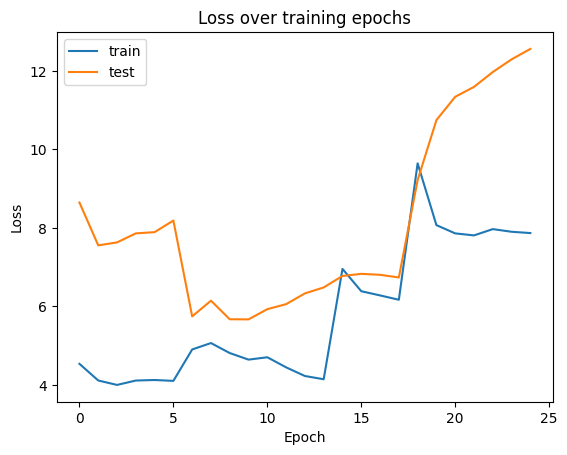

In [71]:
ax = plt.figure().gca()

ax.plot(history['train'][:])
ax.plot(history['val'][:])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [73]:
def predict(model, batch_size, dataset):
  predictions, losses = [], []
  # criterion = nn.MSELoss(reduction='sum').to(device) #L1Loss(reduction='sum').to(device)
  criterion = nn.L1Loss(reduction='sum').to(device) #L1Loss(reduction='sum').to(device) # nn.SmoothL1Loss

  with torch.no_grad():
    model = model.eval()
    # for seq_true in dataset:
    for i in range(0, dataset.shape[0], batch_size):
      seq_true = dataset[i:i+batch_size]
      # seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [74]:
x_train.size()
_, losses_train  = predict(model, batch_size, x_train)
_, losses_test   = predict(model, batch_size, x_test)
_, losses_attack = predict(model, batch_size, attack_tensor)
_, losses_normal = predict(model, batch_size, normal_tensor)

torch.Size([83700, 31])

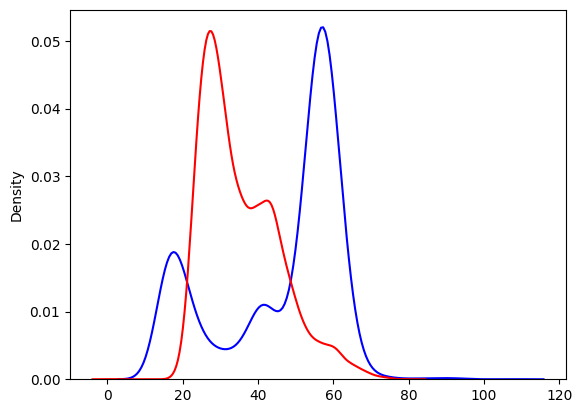

In [76]:
import seaborn as sns
# sns.distplot(losses, bins=50, kde=False);
# sns.kdeplot(losses);
# plt.hist(losses_train, bins=50);
# plt.hist(losses_test, bins=50);
# plt.hist(losses_attack, bins=50);
# plt.hist(losses_normal, bins=50);

sns.kdeplot(losses_normal, color='b');
sns.kdeplot(losses_attack, color='r');
# sns.distplot(losses_normal, bins=50, kde=True);
# sns.distplot(losses_attack, bins=50, kde=True);

In [34]:
# losses_normal = (np.array(losses_normal) / 1000000000)
# losses_attack = (np.array(losses_attack) / 1000000000)

In [77]:
# Brute force compute cutoffs that maximize accuracy  
lower = 23
upper = 58

lower_list = [lower + round(-3+(0.2*i),2) for i in range(31)] # [lower-1,lower-0.5,lower,lower+0.5,lower+1]
upper_list = [upper + round(-3+(0.2*i),2) for i in range(31)] # [upper-1,upper-0.5,upper,upper+0.5,upper+1]
ls_1 = []
ls_2 = []

for i in range(len(lower_list)):
  lower = lower_list[i]
  for i in range(len(upper_list)):
    upper = upper_list[i]

    all_attack = np.array(losses_attack)
    TP = all_attack[(all_attack > lower) & (all_attack < upper)]
    FN = all_attack[(all_attack <= lower) | (all_attack >= upper)]

    all_normal = np.array(losses_normal)
    FP = all_normal[(all_normal > lower) & (all_normal < upper)]
    TN = all_normal[(all_normal <= lower) | (all_normal >= upper)]

    ls_1.append((len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN)))
    ls_2.append((lower, upper))

In [78]:
idx = np.argmax(np.array(ls_1))
# print(ls_1[idx])
# print(ls_2[idx])
lower = ls_2[idx][0]
upper = ls_2[idx][1]

all_attack = np.array(losses_attack)
TP = all_attack[(all_attack > lower) & (all_attack < upper)]
FN = all_attack[(all_attack <= lower) | (all_attack >= upper)]

all_normal = np.array(losses_normal)
FP = all_normal[(all_normal > lower) & (all_normal < upper)]
TN = all_normal[(all_normal <= lower) | (all_normal >= upper)]

ls_1.append((len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN)))
ls_2.append((lower, upper))

print(f'TP: {len(TP)}')
print(f'FN: {len(FN)}')
print(f'TPR: {len(TP)/(len(TP)+len(FN))}')

print(f'TN: {len(TN)}')
print(f'FP: {len(FP)}')
print(f'TNR: {len(TN)/(len(TN)+len(FP))}')

print(f'Accuracy : {(len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))}')
# https://en.wikipedia.org/wiki/Precision_and_recall#Imbalanced_data

TP: 9660
FN: 633
TPR: 0.938501894491402
TN: 3584
FP: 2229
TNR: 0.6165491140547049
Accuracy : 0.8223022476095865
